# ROI Summary by Slide and Group

This notebook aggregates ROI and cell counts (from `HE_ROI_Classification` outputs) by slide and by experimental group. It computes:

- Total detected cells per slide and per group
- Total detected ROIs (nuclei) per slide and per group
- Number of *internal* ROIs (nuclei) per slide and per group

Set `RESULTS_FOLDER` to the folder containing `*_roi_summary.csv` and `*_roi_details.csv` (default: `roi_analysis_results` next to your mask files). Run cells in order.

In [45]:
# 1) Imports and settings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Path to results (change if necessary)
RESULTS_FOLDER = Path(r"S:\micro\ts2625\eh2888\lem\HEImages_0123\newData\roi_analysis_results")
print(f"Looking for results in: {RESULTS_FOLDER}")


Looking for results in: S:\micro\ts2625\eh2888\lem\HEImages_0123\newData\roi_analysis_results


In [46]:
# 2) Read available summary/details CSVs
# Prefer aggregated files if present
agg_summary = RESULTS_FOLDER / 'all_roi_summary.csv'
agg_details = RESULTS_FOLDER / 'all_roi_details.csv'

if agg_summary.exists():
    summary_df = pd.read_csv(agg_summary)
    print(f"Loaded aggregated summary: {agg_summary.name} | rows={len(summary_df)}")
else:
    # load all per-image *_roi_summary.csv files
    files = sorted(RESULTS_FOLDER.glob('*_roi_summary.csv'))
    if not files:
        raise FileNotFoundError(f"No summary CSVs found in {RESULTS_FOLDER}")
    df_list = [pd.read_csv(f) for f in files]
    summary_df = pd.concat(df_list, ignore_index=True)
    print(f"Loaded {len(files)} per-image summary files | total rows={len(summary_df)}")

# Details (to count 'internal' if not present in summary)
if agg_details.exists():
    details_df = pd.read_csv(agg_details)
    print(f"Loaded aggregated details: {agg_details.name} | rows={len(details_df)}")
else:
    files = sorted(RESULTS_FOLDER.glob('*_roi_details.csv'))
    if not files:
        # details optional - will compute internal from summary if present
        details_df = None
        print("No per-image details found; continuing with summary only.")
    else:
        df_list = [pd.read_csv(f) for f in files]
        details_df = pd.concat(df_list, ignore_index=True)
        print(f"Loaded {len(files)} per-image details files | total rows={len(details_df)}")

summary_df.head()

Loaded aggregated summary: all_roi_summary.csv | rows=8
Loaded aggregated details: all_roi_details.csv | rows=884


,image_base,orig_num_cells,removed_small_cells,num_cells,num_rois,n_internal,n_edge,n_outside
0,01_01_03_2,122,5,120,84,0,79,5
1,01_01_04_2,49,4,47,24,0,21,3
2,01_01_04_3,79,5,77,48,1,46,1
3,01_02_02_3,90,6,89,46,1,41,4
4,01_02_03_1,187,9,184,59,0,57,2


In [47]:
# 3) Parse filename base into slide/region/subregion and assign group mapping
import re

def parse_base_to_parts(base_str):
    """Parse a base string like '01_01_02_0' -> dict with slide, region, subregion"""
    if pd.isna(base_str):
        return {
            'orig': base_str,
            'part0': None,
            'slide': None,
            'region': None,
            'subregion': None
        }
    if not isinstance(base_str, str):
        base_str = str(base_str)
    parts = re.split(r'[_-]', base_str)
    # Expect at least 4 parts; if not, try to find numeric parts
    nums = [p for p in parts if p.isdigit()]
    # pad with None
    while len(nums) < 4:
        nums.append(None)
    return {
        'orig': base_str,
        'part0': parts[0] if len(parts)>0 else None,
        'slide': int(nums[1]) if nums[1] is not None else None,
        'region': int(nums[2]) if nums[2] is not None else None,
        'subregion': int(nums[3]) if nums[3] is not None else None
    }


def slide_to_group(slide):
    """Map slide number to group name per project rules.

    For the HSA groups we put "LR" as a superscript over "HSA" using
    matplotlib mathtext (e.g., r'HSA$^{\mathrm{LR}}$-CLAAAV').
    """
    if slide in (1,2,3,4):
        return 'WT-Saline'
    if slide in (5,6,7,8):
        return r'HSA$^{\mathrm{LR}}$-Saline'
    if slide in (9,10,11,12,13):
        return r'HSA$^{\mathrm{LR}}$-CLAAAV'
    if slide in (14,15):
        return 'eGFP'
    return 'Unknown'

# Apply parsing to summary df
if 'image_base' in summary_df.columns:
    summary_df['base'] = summary_df['image_base']
else:
    # try to find a basename column
    for c in summary_df.columns:
        if 'base' in c:
            summary_df['base'] = summary_df[c]
            break

parsed = summary_df['base'].apply(parse_base_to_parts).apply(pd.Series)
summary_df = pd.concat([summary_df, parsed], axis=1)
summary_df['group'] = summary_df['slide'].apply(lambda s: slide_to_group(int(s)) if not pd.isna(s) else 'Unknown')

# Also add parsed fields for details_df if present
if details_df is not None:
    if 'image_base' in details_df.columns:
        details_df['base'] = details_df['image_base']
    parsed_d = details_df['base'].apply(parse_base_to_parts).apply(pd.Series)
    details_df = pd.concat([details_df, parsed_d], axis=1)
    details_df['group'] = details_df['slide'].apply(lambda s: slide_to_group(int(s)) if not pd.isna(s) else 'Unknown')


<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\417069570.py:35: SyntaxWarning: invalid escape sequence '\m'
  matplotlib mathtext (e.g., r'HSA$^{\mathrm{LR}}$-CLAAAV').


In [48]:
# 4) Aggregate per slide and per group
# Use summary_df (prefer provided n_internal column). If not present, compute internal from details_df.

# Ensure fields exist
if 'num_cells' not in summary_df.columns and 'num_cells' in summary_df.columns:
    pass

if 'n_internal' not in summary_df.columns and details_df is not None:
    # compute n_internal per base from details
    intr = details_df[details_df['classification']=='internal'].groupby('base').size().rename('n_internal')
    summary_df = summary_df.merge(intr, how='left', left_on='base', right_index=True)
    summary_df['n_internal'] = summary_df['n_internal'].fillna(0).astype(int)

# Fill missing numeric columns if needed
for col in ['num_cells','num_rois','n_internal']:
    if col not in summary_df.columns:
        summary_df[col] = 0

# Per-slide aggregation
slide_agg = summary_df.groupby('slide').agg(
    slides_count=('base','nunique'),
    total_cells=('num_cells','sum'),
    total_rois=('num_rois','sum'),
    total_internal=('n_internal','sum')
).reset_index()
slide_agg['group'] = slide_agg['slide'].apply(slide_to_group)

# Per-group aggregation - MUST aggregate from summary_df, not slide_agg
group_agg = summary_df.groupby('group').agg(
    slides_count=('slide','nunique'),
    total_cells=('num_cells','sum'),
    total_rois=('num_rois','sum'),
    total_internal=('n_internal','sum')
).reset_index()

print('Per-slide summary:')
print(slide_agg)
print('\nPer-group summary:')
print(group_agg)


Per-slide summary:
   slide  slides_count  total_cells  total_rois  total_internal  \
0      1             3          244         156               1   
1      2             2          273         105               1   
2      5             1          127         183              19   
3      7             1          133         181               8   
4      8             1          236         259              24   

                        group  
0                   WT-Saline  
1                   WT-Saline  
2  HSA$^{\mathrm{LR}}$-Saline  
3  HSA$^{\mathrm{LR}}$-Saline  
4  HSA$^{\mathrm{LR}}$-Saline  

Per-group summary:
                        group  slides_count  total_cells  total_rois  \
0  HSA$^{\mathrm{LR}}$-Saline             3          496         623   
1                   WT-Saline             2          517         261   

   total_internal  
0              51  
1               2  


C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\1557432931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_cells', ax=axes[0], palette='Blues_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\1557432931.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_rois', ax=axes[1], palette='Greens_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\1557432931.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slide_agg.sort_

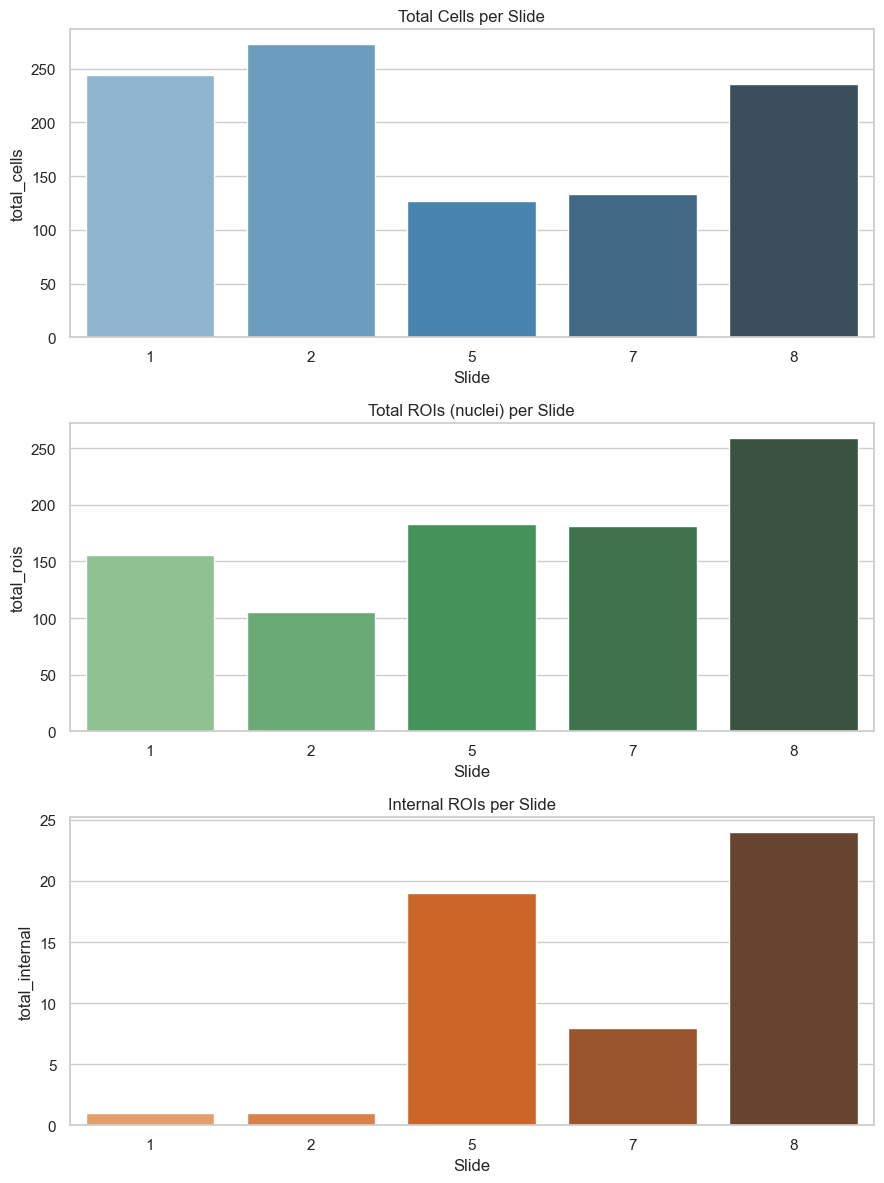

C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\1557432931.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y='total_cells', ax=ax[0], palette='Blues_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\1557432931.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y='total_rois', ax=ax[1], palette='Greens_d')
C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\1557432931.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_agg, x='group', y='total_internal', ax=ax[2], palette=

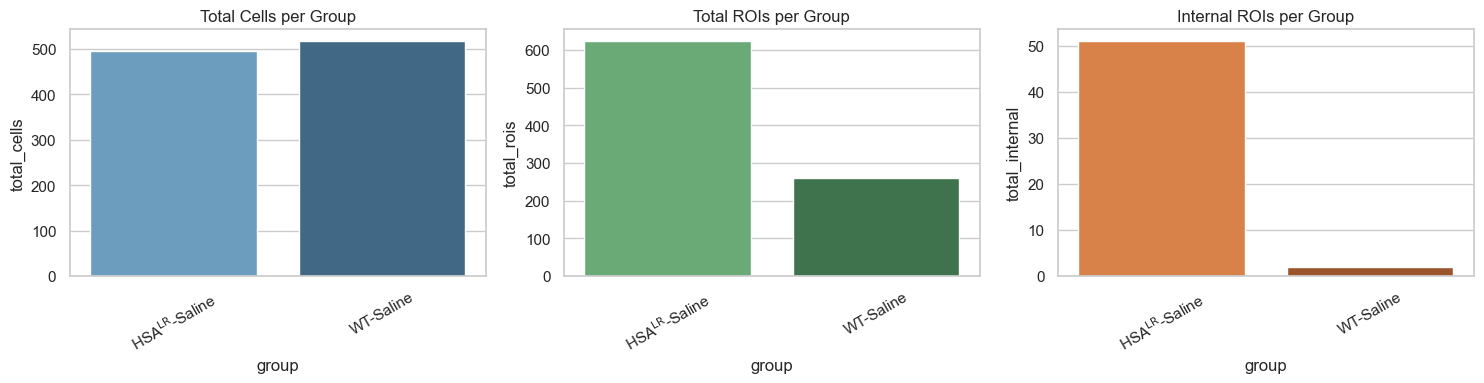

In [49]:
# 5) Visualizations
fig, axes = plt.subplots(3,1, figsize=(9,12))

# Cells per slide
sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_cells', ax=axes[0], palette='Blues_d')
axes[0].set_title('Total Cells per Slide')
axes[0].set_xlabel('Slide')

# ROIs per slide
sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_rois', ax=axes[1], palette='Greens_d')
axes[1].set_title('Total ROIs (nuclei) per Slide')
axes[1].set_xlabel('Slide')

# Internal ROIs per slide
sns.barplot(data=slide_agg.sort_values('slide'), x='slide', y='total_internal', ax=axes[2], palette='Oranges_d')
axes[2].set_title('Internal ROIs per Slide')
axes[2].set_xlabel('Slide')

plt.tight_layout()
plt.show()

# Group-level plots
fig, ax = plt.subplots(1,3, figsize=(15,4))

sns.barplot(data=group_agg, x='group', y='total_cells', ax=ax[0], palette='Blues_d')
ax[0].set_title('Total Cells per Group')
ax[0].tick_params(axis='x', rotation=30)

sns.barplot(data=group_agg, x='group', y='total_rois', ax=ax[1], palette='Greens_d')
ax[1].set_title('Total ROIs per Group')
ax[1].tick_params(axis='x', rotation=30)

sns.barplot(data=group_agg, x='group', y='total_internal', ax=ax[2], palette='Oranges_d')
ax[2].set_title('Internal ROIs per Group')
ax[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


In [50]:
# 6) Save summary tables
out_dir = RESULTS_FOLDER
slide_agg.to_csv(out_dir / 'summary_per_slide.csv', index=False)
group_agg.to_csv(out_dir / 'summary_per_group.csv', index=False)
print(f"Saved slide summary to: {out_dir / 'summary_per_slide.csv'}")
print(f"Saved group summary to: {out_dir / 'summary_per_group.csv'}")


Saved slide summary to: S:\micro\ts2625\eh2888\lem\HEImages_0123\newData\roi_analysis_results\summary_per_slide.csv
Saved group summary to: S:\micro\ts2625\eh2888\lem\HEImages_0123\newData\roi_analysis_results\summary_per_group.csv


C:\Users\zyu\AppData\Local\Temp\ipykernel_12820\15067298.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=plot_df, x='group', y='count', hue='type', order=order, ci=None, palette=['#4C72B0', '#DD8452'])


Saved combined plot to: S:\micro\ts2625\eh2888\lem\HEImages_0123\newData\roi_analysis_results\group_rois_total_internal.png


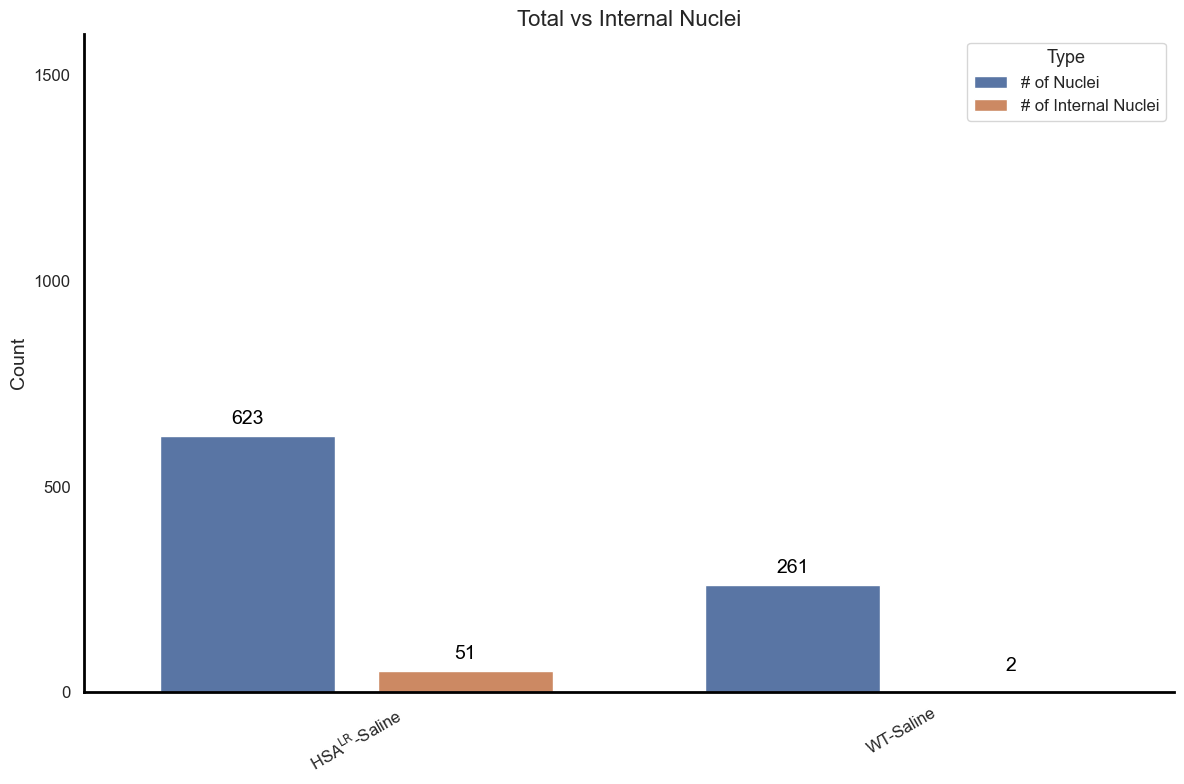

In [51]:
# 7) Combined plot: Total ROIs and Internal ROIs per group (updated style)
if 'group_agg' not in globals():
    raise RuntimeError('group_agg not found - run the aggregation cells first')

# Prepare data for plotting
plot_df = group_agg[['group', 'total_rois', 'total_internal']].melt(id_vars='group', value_vars=['total_rois', 'total_internal'],
                                                                      var_name='type', value_name='count')
plot_df['type'] = plot_df['type'].map({'total_rois': '# of Nuclei', 'total_internal': '# of Internal Nuclei'})

# Plot grouped bars with cleaner style
sns.set_style('white')  # no grid
plt.figure(figsize=(12,8))
order = group_agg['group'].tolist()
ax = sns.barplot(data=plot_df, x='group', y='count', hue='type', order=order, ci=None, palette=['#4C72B0', '#DD8452'])
# Title and labels with larger fonts
ax.set_title('Total vs Internal Nuclei', fontsize=16)
# remove x-axis label per request
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=14)
# Increase tick label size
ax.tick_params(axis='x', rotation=30, labelsize=12)
ax.tick_params(axis='y', labelsize=12, width=2)
ax.grid(False)

# Ensure left and bottom spines are visible (restore axis line) and hide top/right
ax.spines['left'].set_visible(True)
# increase left spine thickness
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Increase tick width for y axis to match thicker spine
ax.tick_params(axis='y', width=2)
# Use seaborn helper to remove top/right spines while preserving left/bottom
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

# Make bars narrower
for p in ax.patches:
    current_width = p.get_width()
    new_width = current_width * 0.8
    diff = current_width - new_width
    p.set_width(new_width)
    p.set_x(p.get_x() + diff / 2)

# Set y-axis ticks explicitly
ymax = max(1600, plot_df['count'].max() * 1.05)
ax.set_ylim(0, ymax)
ax.set_yticks([0, 500, 1000, 1500])

# Add labels on top of bars (skip zero-height bars to avoid stray '0' marks; use clip_on=False)
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height) or height <= 0:
        continue
    # Increase offset for very small bars to avoid collision with nearby text
    offset = 6 if height >= 50 else 12
    ax.annotate(f'{int(round(height))}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=14, color='black', xytext=(0, offset),
                textcoords='offset points', clip_on=False, zorder=10)

# Larger legend text
ax.legend(title='Type', fontsize=12, title_fontsize=13)
plt.tight_layout()

# Save figure
out_path = RESULTS_FOLDER / 'group_rois_total_internal.png'
plt.savefig(out_path, dpi=600, bbox_inches='tight')
print(f"Saved combined plot to: {out_path}")